In [6]:
import cv2
import numpy as np
import time
from IPython.display import display, clear_output
from PIL import Image

In [2]:
import os

In [3]:
from ultralytics import YOLO
model = YOLO("yolov8x.pt")

100%|██████████| 131M/131M [01:19<00:00, 1.72MB/s] 


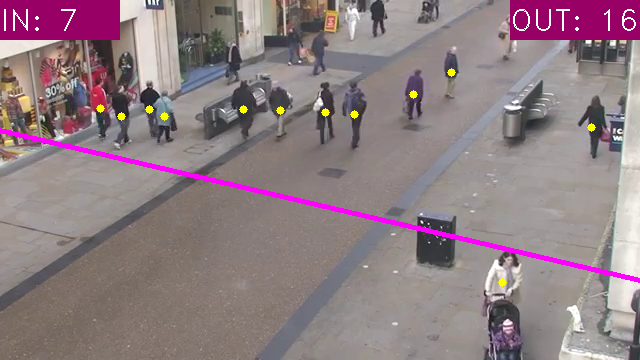

KeyboardInterrupt: 

In [10]:
camara = cv2.VideoCapture("video.mp4")

font = cv2.FONT_HERSHEY_DUPLEX


prev_frame_time = 0

new_frame_time = 0


region1 = np.array([(0, 130), (0, 110), (640, 260), (640, 280)])

region1 = region1.reshape((-1, 1, 2))


region2 = np.array([(0, 130), (0, 150), (640, 300), (640, 280)])

region2 = region2.reshape((-1, 1, 2))


total_ust = set()
total_alt = set()
first_in = set()

first_out = set()


while True:

    new_frame_time = time.time()

    fps = 1 / (new_frame_time - prev_frame_time)

    prev_frame_time = new_frame_time

    ret, frame = camara.read()

    if not ret:

        break


    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    cv2.line(frame, (0, 130), (640, 280), (255, 0, 255), 3)


    results = model.track(rgb_img, persist=True, verbose=False)


    for i in range(len(results[0].boxes)):

        x1, y1, x2, y2 = results[0].boxes.xyxy[i]

        score = results[0].boxes.conf[i]

        cls = results[0].boxes.cls[i]

        ids = results[0].boxes.id[i]


        x1, y1, x2, y2, score, cls, ids = (

            int(x1),
            int(y1),
            int(x2),
            int(y2),
            float(score),
            int(cls),
            int(ids),
        )


        if score < 0.5:
            continue


        if cls != 0:
            continue


        cx = int(x1 / 2 + x2 / 2)

        cy = int(y1 / 2 + y2 / 2)
        cv2.circle(frame, (cx, cy), 4, (0, 255, 255), -1)


        inside_region1 = cv2.pointPolygonTest(region1, (cx, cy), False)
        if inside_region1 > 0:
            if ids in total_alt:
                first_out.add(ids)
                cv2.line(frame, (0, 130), (640, 280), (255, 255, 255), 3)
            total_ust.add(ids)

        inside_region2 = cv2.pointPolygonTest(region2, (cx, cy), False)

        if inside_region2 > 0:
            if ids in total_ust:
                cv2.line(frame, (0, 130), (640, +280), (255, 255, 255), 3)
                first_in.add(ids)
            total_alt.add(ids)


    first_in_str = "IN: " + str(len(first_in))

    first_out_str = "OUT: " + str(len(first_out))


    frame[0:40, 0:120] = (102, 0, 153)

    frame[0:40, 510:640] = (102, 0, 153)

    cv2.putText(frame, first_in_str, (0, 30), font, 1, (255, 255, 255), 1)

    cv2.putText(frame, first_out_str, (510, 30), font, 1, (255, 255, 255), 1)


    # Display the frame in the notebook
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    clear_output(wait=True)

    display(img)


    if cv2.waitKey(1) & 0xFF == ord("q"):

        break


camara.release()
cv2.destroyAllWindows()